# Encompassing Backtester

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from IPython.display import clear_output

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [3]:
df1 = pd.read_csv("../data/CELRUSDT-minute.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/FETUSDT-minute.csv", index_col=0, parse_dates=True)

In [4]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open
df = df[1000:]
df = df.dropna()

## Hedge Ratio calculation

In [5]:
ds = 50 #downsample
hedge_ratio = np.full(df.shape[0], np.nan)
l = math.floor(len(hedge_ratio)/ds)
index = []
for t in np.arange(l):
    clear_output()
    print(f"{t} < {l}")
    regress_results = sm.ols(formula="B ~ A",
                             data=df[:t*ds+1]).fit()  # Note this can deal with NaN in top row
    hedge_ratio[t] = regress_results.params[1]
    index.append(df.index[t*ds+1])

24231 < 24232


In [6]:
hr = pd.Series(hedge_ratio).dropna().rename("hr").to_frame()

hr["index"] = index
hr.set_index("index", inplace=True)

spread = pd.DataFrame(hr.hr, index=df.index)

spread.ffill(inplace=True)

spread = pd.Series((df['B'] - spread["hr"] * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(4000).mean()
spread["std"] =  spread.spread.rolling(4000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

spread = spread.dropna()

spread["A"] = df1["close"].reindex(spread.index)
spread["Ah"] = df1["high"].reindex(spread.index)
spread["Al"] = df1["low"].reindex(spread.index)

spread["B"] = df2["close"].reindex(spread.index)
spread["Bh"] = df2["high"].reindex(spread.index)
spread["Bl"] = df2["low"].reindex(spread.index)

# spread.index = (range(len(spread))) #If using XXXUSDT-past.csv

In [7]:
print(len(spread))
spread = spread[-700_000:]

1207637


## Backtester

In [8]:
spread.index[697].minute

0

In [9]:
def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

def run_backtest(spread, thres, sell_thres, fee=0.002, interest=0.002):
    total, p_total = 0, 0 #Previous total
    cusum, returns = [], []
    price_a, price_b, long = None, None, None #Values: None, "A", "B"
    long_a, long_b, liquidate,  dd_indices= [], [], [], [] #Drawdown indicies
    dd_i = True
    for i in range(spread.shape[0]):
        z = spread.zscore[i]
        if long == None: # Looking to buy
            if z>thres or z<-thres:
                al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
                price_a = ah if z > thres else al
                price_b = bl if z > thres else bh
                long = "A" if z > thres else "B"
                long_a.append(spread.index[i]) if z > thres else long_b.append(spread.index[i])
        if (long == "A" and z<-sell_thres) or (long == "B" and z>sell_thres): #Liquidate positions
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            gain = 0
            if long=="A":
                gain = liquidate_assets(price_b, bh, al, price_a, fee, long_a[-1], spread.index[i], interest)
            else:
                gain = liquidate_assets(price_a, ah, bl, price_b, fee, long_b[-1], spread.index[i], interest)
            returns.append(gain)
            total += gain
            price_a, price_b, long = None, None, None
            liquidate.append(spread.index[i])
        cusum.append(total)

        if total < p_total:
            if dd_i:
                dd_indices.append(spread.index[i])
                dd_i = False
        else:
            if not dd_i:
                dd_indices.append(spread.index[i])
                dd_i = True
            p_total = total
    if total < p_total:
        dd_indices.append(spread.index[i])
    drawdowns = get_drawdowns(dd_indices)
    return long_a, long_b, liquidate, cusum, returns, drawdowns
        
def liquidate_assets(x1, x2, y1, y2, fee, d1, d2, interest):
    interest = ((d2-d1).days + 1) * interest
    total = (x1 - x2)/x1 - 2*fee - interest
    total += (y1 - y2)/y1 - 2*fee - interest
    return total

def get_drawdowns(dd_indices):
    a = dd_indices[1::2]
    b = dd_indices[::2]
    a = np.array(a)
    b = np.array(b[:len(a)])
    c = a-b
    c.sort()
    return c[::-1]

In [15]:
import numpy as np
import pandas as pd
import scipy.stats as st
import math
from tqdm import tqdm

## Monte Carlo

### Monte Carlo Returns

In [18]:
daily_returns = pd.read_csv('../data/returnss2.csv')

ret = daily_returns['0'].to_list()

In [10]:
# The metric to use to measure the input data
# for "predict the market" strategies, can be close price or market returns
# can use z-score for this strategy
zscore_metric = spread.zscore

#daily returns of strategy
#ret

In [13]:
skew_, loc_, scale_ = st.pearson3.fit(zscore_metric)
num_better_samples = 0

In [19]:
sample_size = 100
ret_sims = []

for sample in tqdm(range(sample_size)):
    zscore_sim = st.pearson3.rvs(skew=skew_, loc=loc_, scale=scale_, size=zscore_metric.shape[0], random_state=sample)
    
    spread_sim = spread
    spread_sim['zscore'] = zscore_sim
    
    ret_sim = run_backtest(spread_sim, 2.0, 0.)[4]
    ret_sims.append(ret_sim)
    
    if (np.mean(ret_sim) >= np.mean(ret)):
        num_better_samples += 1
            
print("Randomized zscore: p-value = %f" % (num_better_samples / sample_size))

100%|██████████| 100/100 [22:14<00:00, 13.35s/it]

Randomized zscore: p-value = 0.000000


In [22]:
d2 = pd.DataFrame(ret_sims)

In [23]:
d2

,0,1,2,3,4,5,6,7,8,9,...,76448,76449,76450,76451,76452,76453,76454,76455,76456,76457
0,0.006688,-0.002826,-0.012000,-0.018195,-0.012000,-0.034318,-0.005865,-0.009340,-0.012000,-0.022221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.012000,-0.016630,-0.002826,-0.019254,-0.012000,-0.042643,-0.044450,-0.026948,0.001853,-0.012000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.033760,-0.022790,-0.028563,-0.017419,-0.014077,-0.008819,-0.012000,-0.012000,-0.004159,-0.004153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.010625,-0.021259,-0.022150,-0.021375,-0.014060,-0.020299,-0.002991,0.001613,-0.017618,-0.007370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.016630,-0.016536,0.001738,-0.014077,-0.015185,-0.012000,-0.012000,-0.009761,-0.027906,-0.007595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.025324,0.000703,-0.009927,-0.012000,-0.021259,-0.012000,-0.031871,-0.027103,-0.012000,-0.003228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,-0.012527,-0.012000,-0.010303,-0.014077,-0.002909,-0.036321,-0.030727,-0.006781,-0.002722,-0.012000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,-0.040046,-0.003353,-0.014060,-0.012000,-0.023168,-0.013047,-0.008145,-0.003890,-0.018417,-0.030692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,-0.015978,-0.006360,-0.013031,-0.005865,-0.013047,-0.015191,-0.013070,-0.003480,-0.026874,-0.012000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
long_a, long_b, liquidate, cusum, returns, drawdowns = run_backtest(spread, 2., 0.)

<AxesSubplot:>

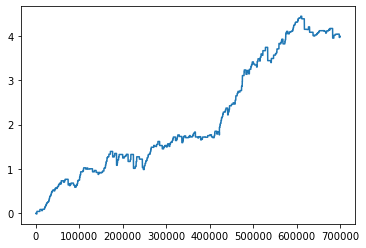

In [107]:
pd.Series(cusum).plot()

<AxesSubplot:>

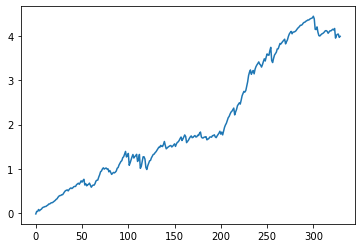

In [122]:
pd.Series(returns).cumsum().plot()

In [108]:
len(list(filter(lambda x: x>0, returns)))

250

In [173]:
d = {"A":[[1, 2, 3], [2, 3, 4]], "B":[3, 4]}

In [174]:
d = pd.DataFrame(d)

In [175]:
d.to_csv("returnss.csv", index=False)

In [176]:
d = pd.read_csv("returnss.csv")
d

,A,B
0,"[1, 2, 3]",3
1,"[2, 3, 4]",4


In [177]:
import ast

In [178]:
ast.literal_eval(d.A[0])

[1, 2, 3]

In [179]:
d["A"] = list(map(lambda x: list(ast.literal_eval(x)), d.A))
d

,A,B
0,"[1, 2, 3]",3
1,"[2, 3, 4]",4


In [109]:
def get_wins_and_losses(returns):
    wins = len(list(filter(lambda x: x>0, returns)))
    losses = len(list(filter(lambda x: x<=0, returns)))
    return wins, losses

def get_average_win_loss(returns):
    wins = np.mean(list(filter(lambda x: x>0, returns)))
    losses = np.mean(list(filter(lambda x: x<=0, returns)))
    return wins, losses

def get_winning_losing_streak(returns):
    w, p_w = 0, 0
    l, p_l = 0, 0
    for trade in returns:
        if trade > 0:
            w += 1
            p_l = l if l>p_l else p_l
            l = 0
        else:
            l += 1
            p_w = w if w>p_w else p_w
            w = 0
    return p_w, p_l

In [116]:
a, b = get_wins_and_losses(returns)

In [118]:
b

80

In [80]:
pd.Series(returns).to_csv("returnss.csv", index=False)

In [34]:
drawdowns

array([Timedelta('50 days 05:48:00'), Timedelta('26 days 20:40:00'),
       Timedelta('25 days 22:50:00'), Timedelta('22 days 08:35:00'),
       Timedelta('21 days 21:32:00'), Timedelta('18 days 23:44:00'),
       Timedelta('12 days 02:01:00'), Timedelta('9 days 09:46:00'),
       Timedelta('6 days 01:04:00'), Timedelta('5 days 13:29:00'),
       Timedelta('5 days 11:06:00'), Timedelta('5 days 09:25:00'),
       Timedelta('3 days 16:40:00'), Timedelta('3 days 06:28:00'),
       Timedelta('3 days 00:53:00'), Timedelta('2 days 06:02:00'),
       Timedelta('2 days 03:53:00'), Timedelta('1 days 17:16:00'),
       Timedelta('1 days 14:58:00'), Timedelta('1 days 07:37:00'),
       Timedelta('1 days 07:21:00'), Timedelta('1 days 05:44:00')],
      dtype=object)

In [76]:
def strategy_score(long_a, long_b, liquidate, cusum, returns, drawdowns):
    score = 0.
    time_length = (liquidate[-1]-liquidate[0]).days
    
    # How many trades, where more is better, but very low priority. 
    # Score=1 if one trade a day, 2 if twice a day, 0.5 if one trade every 2 days. 
    # [0, 3]
    points = min(len(liquidate)/time_length, 3)
    print(f"{round(points, 2)} from [0, 3]: How many trades")
    score += points
    
    # Max drawdown length compared to 50 days
    # [-40, 20]
    points = max(min(20-drawdowns[0].days/5, 20), -40)
    print(f"{round(points, 2)} from [-40, 20]: Max drawdown length")
    score += points
    
    # Number of drawdowns lasting for more than a week
    # [-5, 5]
    points = max(min(5-len(list(filter(lambda x: x.days>=6, drawdowns))), 5), -5)
    print(f"{round(points, 2)} from [-5, 5]: Number of drawdowns lasting for more than a week")
    score += points
    
    # Biggest loss
    # [-40, 20], where -40 is 60% or more, and 20 is 0%
    points = max(min(20+np.min(returns)*100, 20), -40)
    print(f"{round(points, 2)} from [-40, 20]: Biggest loss")
    score += points
    
    # Number of 15% losses
    # [-20, 20], where -20 is 20 or more, and 20 is 0
    points = max(min(20-len(np.array(returns)[np.array(returns)<-0.15]), 20), -20)
    print(f"{round(points, 2)} from [-20, 20]: Number of 15% losses")
    score += points
    
    # Cumulative returns
    # [-inf, inf], where 5 is 100 and 0 is 0
    points = 20*cusum[-1]
    print(f"{round(points, 2)} from [-inf, -inf]: Cumulative returns")
    score += points
    
    return score

In [77]:
strategy_score(long_a, long_b, liquidate, cusum, returns, drawdowns)

0.68 from [0, 3]: How many trades
7.8 from [-40, 20]: Max drawdown length
-5 from [-5, 5]: Number of drawdowns lasting for more than a week
-11.32 from [-40, 20]: Biggest loss
12 from [-20, 20]: Number of 15% losses
79.83 from [-inf, -inf]: Cumulative returns


83.98755987934706

In [158]:
np.array(returns[-50:]).mean()

-0.0029742338808068235

485